<a href="https://colab.research.google.com/github/windopper/NLPDeepLearningPractice/blob/main/TextClassificationUsingRNN/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 스팸 메일 분류하기 (Spam Detection)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [6]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


데이터 전처리

In [7]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


중복 여부 확인

In [9]:
print(len(data['v2'].unique()))

5169


중복 제거

In [10]:
data.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플 수 :', len(data))

총 샘플 수 : 5169


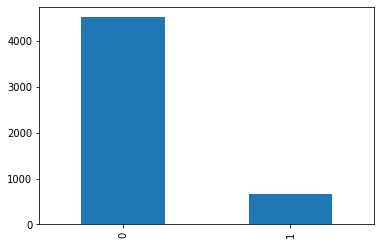

In [11]:
data['v1'].value_counts().plot(kind='bar')

In [12]:
print('정상 메일과 스팸 메일의 여부')
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 여부
   v1  count
0   0   4516
1   1    653


In [13]:
print(f'정상 메일의 비율 {round(data["v1"].value_counts()[0]/len(data) * 100, 3)}%')
print(f'스팸 메일의 비율 {round(data["v1"].value_counts()[1]/len(data) * 100, 3)}%')

정상 메일의 비율 87.367%
스팸 메일의 비율 12.633%


In [14]:
x_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수 : ', len(x_data))
print('레이블의 개수 : ', len(y_data))

메일 본문의 개수 :  5169
레이블의 개수 :  5169


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data)

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train_encoded = tokenizer.texts_to_sequences(x_train)
print(x_train_encoded[:5])

[[2351, 1833, 57, 221, 566, 14, 97, 3527, 10, 186, 4, 270, 69, 69, 36, 3528, 47, 49, 42, 4, 567, 1528, 201, 1529, 627, 20, 47, 20, 89, 1312, 42, 4, 1313, 201, 64, 863, 205, 205], [153, 1, 64, 3, 2352, 13, 568, 8, 1834], [4, 1835, 1165, 1836, 59, 45, 44, 4, 344, 2353, 9, 3529, 430, 7, 808, 3, 701, 4, 702, 569, 1835, 12, 45, 44], [43, 21, 3, 1314, 41], [116, 85, 668, 2, 1046]]


In [17]:
word_to_index = tokenizer.word_index

In [18]:
vocab_size = len(word_to_index)+1
print('단어 집합의 크기 ', vocab_size)

단어 집합의 크기  7896


메일의 최대 길이 : 189
메일의 평균 길이 : 15.720677


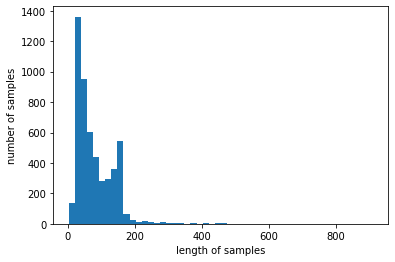

In [19]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in x_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, x_train_encoded))/len(x_train_encoded)))
plt.hist([len(sample) for sample in x_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
max_len = 189
x_train_padded = pad_sequences(x_train_encoded, maxlen=max_len)
print('훈련 데이터의 크기(shape) :', x_train_padded.shape)

훈련 데이터의 크기(shape) : (4135, 189)


# RNN으로 스팸 메일 분류

In [21]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(x_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
52/52 [==============================] - 25s 381ms/step - loss: 0.4122 - acc: 0.8446 - val_loss: 0.1696 - val_acc: 0.9710
Epoch 2/4
52/52 [==============================] - 9s 177ms/step - loss: 0.1223 - acc: 0.9689 - val_loss: 0.0818 - val_acc: 0.9794
Epoch 3/4
52/52 [==============================] - 9s 165ms/step - loss: 0.0611 - acc: 0.9840 - val_loss: 0.0573 - val_acc: 0.9855
Epoch 4/4
52/52 [==============================] - 9s 168ms/step - loss: 0.0682 - acc: 0.9800 - val_loss: 0.1196 - val_acc: 0.9637


In [26]:
x_test_encoded = tokenizer.texts_to_sequences(x_test)
x_test_padded = pad_sequences(x_test_encoded, maxlen=max_len)
print('\n 테스트 정확도 : %.4f' % (model.evaluate(x_test_padded, y_test)[1]))

33/33 [==============================] - 1s 30ms/step - loss: 0.0848 - acc: 0.9691

 테스트 정확도 : 0.9691


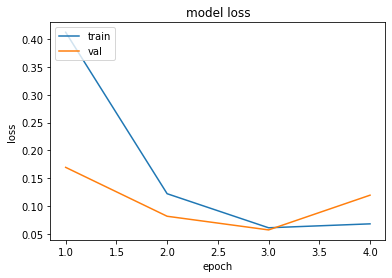

In [27]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()